<a href="https://colab.research.google.com/github/radhika281/EVA-4.0/blob/master/Radhika_ASN6_EVA4S6F3_model3_lat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

#Code 3 with L2 Regularization
Target:

    1.Added L2 regularization
    2.Results:
        Parameters: 6070
        Best Train Accuracy: 98.5
        Best Test Accuracy: 98.04
    3.Analysis:
        We have started to less over-fitting now. 
        But still needs improvement.
        Number of parameters have significantly reduced

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


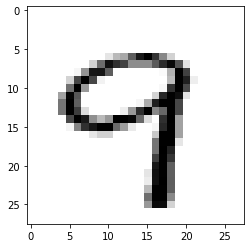

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

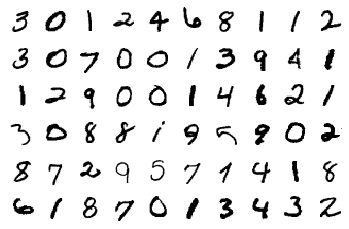

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
 #       self.convblock8 = nn.Sequential(
 #           nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
 #           # nn.ReLU() NEVER!
 #       ) # output_size = 1

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self,x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        #x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200
      BatchNorm2d-13           [-1, 10, 11, 11]              20
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = 0.001)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.4528687298297882 Batch_id=468 Accuracy=82.02: 100%|██████████| 469/469 [00:12<00:00, 39.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4732, Accuracy: 9091/10000 (90.91%)

EPOCH: 1


Loss=0.20156359672546387 Batch_id=468 Accuracy=95.89: 100%|██████████| 469/469 [00:12<00:00, 37.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3351, Accuracy: 9252/10000 (92.52%)

EPOCH: 2


Loss=0.16763465106487274 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:11<00:00, 39.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2123, Accuracy: 9578/10000 (95.78%)

EPOCH: 3


Loss=0.1597568839788437 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:11<00:00, 39.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2480, Accuracy: 9393/10000 (93.93%)

EPOCH: 4


Loss=0.12260937690734863 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:11<00:00, 42.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2034, Accuracy: 9503/10000 (95.03%)

EPOCH: 5


Loss=0.17147809267044067 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1554, Accuracy: 9666/10000 (96.66%)

EPOCH: 6


Loss=0.09988268464803696 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:11<00:00, 40.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1479, Accuracy: 9643/10000 (96.43%)

EPOCH: 7


Loss=0.06761808693408966 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:12<00:00, 37.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1289, Accuracy: 9718/10000 (97.18%)

EPOCH: 8


Loss=0.13828638195991516 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:11<00:00, 39.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1506, Accuracy: 9650/10000 (96.50%)

EPOCH: 9


Loss=0.08903322368860245 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:12<00:00, 36.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1504, Accuracy: 9611/10000 (96.11%)

EPOCH: 10


Loss=0.06816935539245605 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:11<00:00, 40.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1347, Accuracy: 9720/10000 (97.20%)

EPOCH: 11


Loss=0.06738320738077164 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:11<00:00, 40.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1196, Accuracy: 9721/10000 (97.21%)

EPOCH: 12


Loss=0.11827898025512695 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:11<00:00, 41.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1195, Accuracy: 9706/10000 (97.06%)

EPOCH: 13


Loss=0.09470552951097488 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:11<00:00, 41.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1079, Accuracy: 9776/10000 (97.76%)

EPOCH: 14


Loss=0.10920590162277222 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:11<00:00, 40.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1301, Accuracy: 9664/10000 (96.64%)

EPOCH: 15


Loss=0.14044040441513062 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:10<00:00, 43.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1080, Accuracy: 9743/10000 (97.43%)

EPOCH: 16


Loss=0.08447424322366714 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:11<00:00, 42.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0911, Accuracy: 9808/10000 (98.08%)

EPOCH: 17


Loss=0.12059275060892105 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:10<00:00, 43.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1177, Accuracy: 9738/10000 (97.38%)

EPOCH: 18


Loss=0.1065007746219635 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:10<00:00, 42.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0902, Accuracy: 9804/10000 (98.04%)

EPOCH: 19


Loss=0.10578908771276474 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:11<00:00, 42.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1228, Accuracy: 9682/10000 (96.82%)

EPOCH: 20


Loss=0.09759034961462021 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:10<00:00, 45.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0930, Accuracy: 9773/10000 (97.73%)

EPOCH: 21


Loss=0.08769097179174423 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:10<00:00, 43.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0909, Accuracy: 9817/10000 (98.17%)

EPOCH: 22


Loss=0.09780585020780563 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:10<00:00, 45.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0910, Accuracy: 9807/10000 (98.07%)

EPOCH: 23


Loss=0.07893511652946472 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:10<00:00, 43.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1274, Accuracy: 9697/10000 (96.97%)

EPOCH: 24


Loss=0.0549740307033062 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:10<00:00, 43.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0951, Accuracy: 9770/10000 (97.70%)

EPOCH: 25


Loss=0.11438839882612228 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:10<00:00, 46.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0958, Accuracy: 9802/10000 (98.02%)

EPOCH: 26


Loss=0.11781077831983566 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:10<00:00, 44.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0853, Accuracy: 9830/10000 (98.30%)

EPOCH: 27


Loss=0.10862646251916885 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:10<00:00, 45.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0891, Accuracy: 9798/10000 (97.98%)

EPOCH: 28


Loss=0.05124509334564209 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:10<00:00, 43.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0945, Accuracy: 9791/10000 (97.91%)

EPOCH: 29


Loss=0.06125146523118019 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:10<00:00, 43.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0812, Accuracy: 9832/10000 (98.32%)

EPOCH: 30


Loss=0.05089689791202545 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:10<00:00, 44.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0706, Accuracy: 9842/10000 (98.42%)

EPOCH: 31


Loss=0.13826681673526764 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:10<00:00, 43.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0775, Accuracy: 9830/10000 (98.30%)

EPOCH: 32


Loss=0.13794581592082977 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:10<00:00, 45.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0695, Accuracy: 9877/10000 (98.77%)

EPOCH: 33


Loss=0.06245048716664314 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:10<00:00, 44.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0742, Accuracy: 9845/10000 (98.45%)

EPOCH: 34


Loss=0.07259935140609741 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:10<00:00, 42.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0770, Accuracy: 9838/10000 (98.38%)

EPOCH: 35


Loss=0.07989777624607086 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:10<00:00, 44.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0909, Accuracy: 9779/10000 (97.79%)

EPOCH: 36


Loss=0.021789560094475746 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:10<00:00, 43.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0847, Accuracy: 9795/10000 (97.95%)

EPOCH: 37


Loss=0.05800491198897362 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:10<00:00, 44.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0902, Accuracy: 9786/10000 (97.86%)

EPOCH: 38


Loss=0.13149051368236542 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:10<00:00, 44.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0782, Accuracy: 9836/10000 (98.36%)

EPOCH: 39


Loss=0.07272890210151672 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:10<00:00, 43.14it/s]



Test set: Average loss: 0.0833, Accuracy: 9804/10000 (98.04%)



Text(0.5, 1.0, 'Test Accuracy')

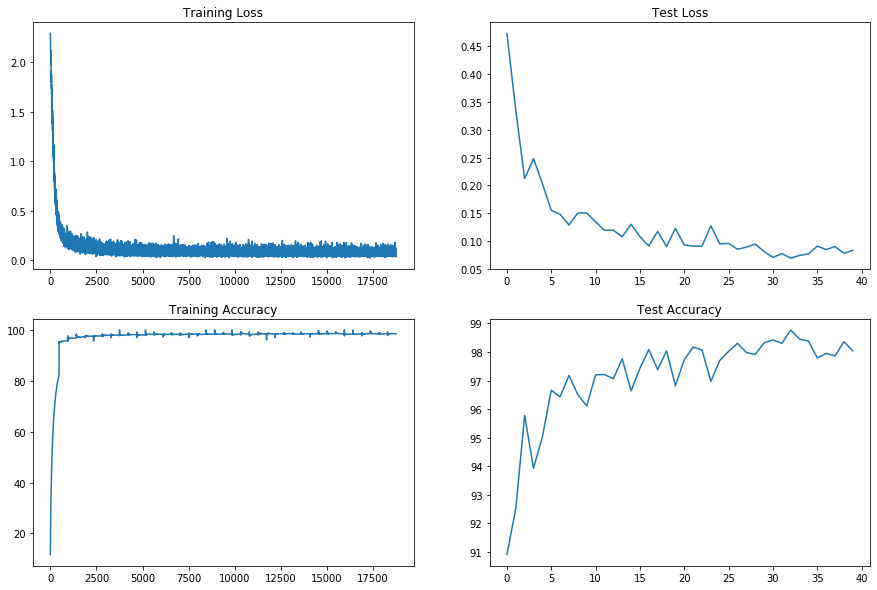

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")